In [44]:
from bpd.sample import sample_galaxy_params_simple
from functools import partial 

import jax 
from jax import vmap

import jax.numpy as jnp

import matplotlib.pyplot as plt 

In [45]:
seed = 42 
k = jax.random.key(42)
keys = jax.random.split(k, 10000)

## Image size

In [54]:
# image size
import galsim 
def get_exponential_size(f, hlr, e1, e2, psf_hlr):

    gal = galsim.Exponential(flux=f, half_light_radius=hlr)
    gal = gal.shear(g1=e1, g2=e2)  # intrinsic ellipticity

    psf = galsim.Gaussian(flux=1.0, half_light_radius=psf_hlr)
    gal_conv = galsim.Convolve([gal, psf])
    return gal_conv.getGoodImageSize(0.2)


In [63]:
get_exponential_size(1e4, 10**(-0.3+0.15), 0.3, 0.3, psf_hlr=0.7)

66

## SNR

In [64]:
_sample_fnc = partial(sample_galaxy_params_simple, 
                      shape_noise=0.1, mean_logflux=2.6, sigma_logflux=0.4, mean_loghlr=-0.3, sigma_loghlr=0.05)
galaxy_params = vmap(_sample_fnc)(keys)

In [65]:
draw_params = {**galaxy_params}
draw_params['f'] = 10**draw_params.pop("lf")
draw_params['hlr'] = 10**draw_params.pop("lhlr")
draw_params['x'] = jnp.zeros_like(draw_params['x'])
draw_params['y'] = jnp.zeros_like(draw_params['y'])

draw_params.keys()

dict_keys(['e1', 'e2', 'g1', 'g2', 'x', 'y', 'f', 'hlr'])

In [66]:
from bpd.draw import draw_exponential_galsim
from tqdm import tqdm


_draw_galsim = partial(draw_exponential_galsim, slen=63)
noiseless = [] 



for ii in tqdm(range(10000)):
    _params = {k:v[ii] for k,v in draw_params.items()}
    noiseless.append(_draw_galsim(**_params))


noiseless = jnp.stack(noiseless, axis=0)

100%|██████████| 10000/10000 [01:20<00:00, 123.60it/s]


In [68]:
noiseless.shape

(10000, 63, 63)

In [69]:
from bpd.utils import get_snr

snrs = [] 
for ii in tqdm(range(10000)):
    snrs.append(get_snr(noiseless[ii], 1.0))

snrs = jnp.stack(snrs, axis=0)

100%|██████████| 10000/10000 [00:05<00:00, 1751.76it/s]


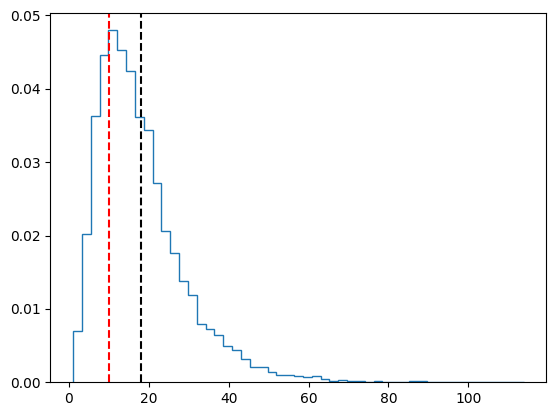

In [75]:
plt.hist(snrs, bins=51, histtype='step', density=True)
plt.axvline(snrs.mean(), linestyle='--', color='k')
plt.axvline(10.0, linestyle='--', color='r')

In [71]:
jnp.median(snrs), snrs.mean()

(Array(15.554792, dtype=float32), Array(18.010311, dtype=float32))

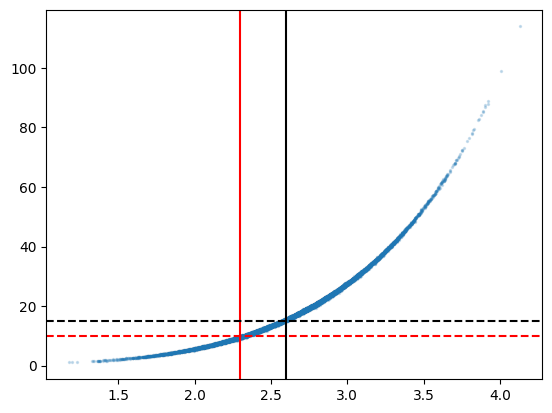

In [81]:
plt.scatter(galaxy_params['lf'],  snrs, marker='o', s=2., alpha=0.2)
plt.axhline(10., color='r', linestyle='--')
plt.axvline(2.3, color='r')

plt.axhline(15., color='k', linestyle='--')
plt.axvline(2.6, color='k', linestyle='-')